In [4]:
import numpy as np
from numpy.random import standard_normal
import matplotlib.pyplot as plt
import math
import scipy.optimize as sopt
from scipy.integrate import quad,dblquad,nquad
from scipy.stats import norm, ncx2

## Define the function of integration value

In [5]:
def bigC(kappa, rho, nu, theta, v0):
    def fk(u, t, k):
        alpha = -(u**2)/2 - (1j*u)/2 + 1j*k*u
        beta = kappa - rho*nu*1j*u - rho*nu*k
        gamma = (nu**2)/2
        d = np.sqrt(beta**2 - 4*alpha*gamma)   # similar to the determinant
        rp = (beta + d) / (2 * gamma)
        rm = (beta - d) / (2 * gamma)
        g = rm / rp
        C_JG = kappa * (rm*t - (2/(nu**2))*np.log((1-g*np.exp(-d*t)/(1-g))))
        C_Heston = kappa * (rp*t - (2/(nu**2))*np.log(((np.exp(d*t)-g)/(1-g))))
        return [C_JG, C_Heston]   # JG is the method from "Jim Gatheral"
    return fk

BCC = bigC(kappa=1.15, rho=-0.64, nu=0.39, theta=0.04, v0=0.04)

### Large difference in imaginary parts.

In [6]:
BCC(u=10, t=3, k=0)

[(-50.67937877608699+32.280020896014435j),
 (-47.5424985325402+121.85082406177675j)]


## Visulize this difference:

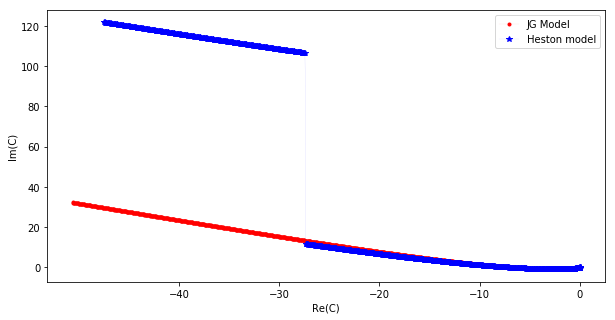

In [7]:
u_vec = np.arange(0, 10, 0.01)
x = BCC(u=u_vec, t=3, k=0)
plt.figure(figsize=(10, 5))
plt.xlabel('Re(C)')
plt.ylabel('Im(C)')
plt.xticks([-40, -30, -20, -10, 0])
plt.yticks([0, 20, 40, 60, 80, 100, 120])
plt.plot(np.real(x[0]),np.imag(x[0]),color='red',linewidth=0.05,linestyle='-',marker='.')
plt.plot(np.real(x[1]), np.imag(x[1]),color='blue',linewidth=0.05,linestyle = '-',marker='*')
plt.legend(['JG Model','Heston model'],loc='upper right')

plt.show()

# Black-Scholes

In [8]:
"""Black Scholes Formula"""
def BSFormula(spot, strike, texp, intr, vol):
    x = np.log(spot/strike) + intr*texp
    sig = vol*np.sqrt(texp)
    d1 = x/sig + sig/2
    d2 = d1 - sig
    pv = np.exp(-intr*texp)
    return spot*norm.cdf(d1) - pv*strike*norm.cdf(d2)

# Implied volatility

In [9]:
def BSImplieVolCall(spot, strike, texp, intr, call_price):
    def func(x):
        vol = np.exp(x)  # make restricts on the volatility > 0
        price_dff = BSFormula(spot, strike, texp, intr, vol) - call_price
        return price_dff
    # find the root
    sol = sopt.root(func, 0)
    solution = sol.x
    
    vol = np.exp(solution)
    return list(vol)  # use list to avoid the dataframe is "array"

### numerical examples

In [10]:
vols = [0.23, 0.20, 0.18]
strike = [0.9, 1.0, 1.1]
spot, texp, intr = [1, 1, 1], [1, 1, 1], [0, 0, 0]
optVals = list(map(BSFormula, spot, strike, texp, intr, vols))
impVols = list(map(BSImplieVolCall, spot, strike, texp, intr, optVals))
print(optVals, impVols)

[0.14589696039054434, 0.07965567455405798, 0.03557677896057376] [[0.23000000000001225], [0.20000000000001183], [0.17999999999999974]]


# Heston formula

In [11]:
# pricing formula with assumption that intr = 0
# we need add more argument related to the intr
def callHeston(kappa, rho, nu, theta, v0):
    # m is the strike price
    # t is the time to maturity
    def res(m, t):  
        # u is log(S)
        # t is the same as what in function res(m, t)
        # k is an indicator, we will assign it with value 0 or 1, to indicate two different funtion that we will use
        def fk(u, t, k):  
            alpha = -u*u/2 - 1j*u/2 + 1j*k*u
            beta = kappa - rho*nu*1j*u - rho*nu*k
            gamma = (nu**2) / 2
            d = np.sqrt(beta**2 - 4*alpha*gamma)
            rp = (beta + d) / (2 * gamma)
            rm = (beta - d) / (2 * gamma)
            g = rm / rp
            D = rm * (1 - np.exp(-d*t)) / (1 - g*np.exp(-d*t))
            C = kappa * (rm*t - (2/(nu**2))*np.log((1-g*np.exp(-d*t))/(1-g)))
            return np.exp(C*theta + D*v0)
        x = - m
        p1 = 0.5 + 1/np.pi*(quad(lambda u: np.real(fk(u, t, 1)*np.exp(1j*u*x)/(1j*u)), 0, np.inf)[0])
        # the above is defining a function Pj when j = 1
        p0 = 0.5 + 1/np.pi*(quad(lambda u: np.real(fk(u, t, 0)*np.exp(1j*u*x)/(1j*u)), 0, np.inf)[0])
        return (np.exp(m)*(np.exp(x)*p1-p0))
    return res  # Return price of Heston call

# Heston probability density function

In [12]:
def pdf_Heston(kappa, rho, nu, theta, v0):
    def res(m, t):
        def fk(u, t, k):
            alpha = -u*u/2 - 1j*u/2 + 1j*k*u
            beta = kappa - rho*nu*1j*u - rho*nu*k
            gamma = (nu**2) / 2
            d = np.sqrt(beta**2 - 4*alpha*gamma)
            rp = (beta + d) / (2 * gamma)
            rm = (beta - d) / (2 * gamma)
            g = rm / rp
            D = rm * (1 - np.exp(-d*t)) / (1 - g*np.exp(-d*t))
            # By using Jim Gatheral's big C
            C = kappa * (rm*t - (2/(nu**2))*np.log((1-g*np.exp(-d*t))/(1-g)))
            return np.exp(C*theta + D*v0)
        x = - m
        p =  1/np.pi*(quad(lambda u: np.real(fk(u, t, 0)*np.exp(-1j*u*x)), 0, np.inf)[0])
        return p
    return res  # Return the probabiloty of Heston call

## 1. Heston smile with BCC parameter

In [13]:
# use the 'callHeston' function to calculate the price,
# and use it as an argument in BSM implied volatility function.
def impvolHeston(kappa, rho, nu, theta, v0):
    def f(k, t):  # k is the strike price
        # use exp(k) instead of k because later we will draw graph with x-label 'log-strike k'
        # so do this transformation to make k consistent
        # i.e. log(exp(k)) == k
        return BSImplieVolCall(1, np.exp(k), t, 0, callHeston(kappa, rho, nu, theta, v0)(k, t))
    return f

In [14]:
log_strike = np.arange(-0.5, 0.5, 0.01)

# the time to maturity is 1, i.e. t = 1
f = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

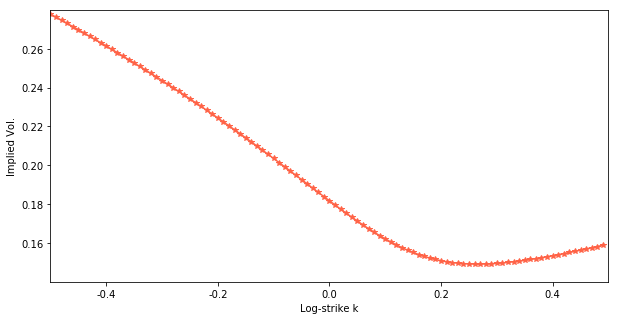

In [15]:
plt.figure(figsize=(10, 5))
plt.ylabel('Implied Vol.')
plt.xlabel('Log-strike k')
plt.xlim(-0.5, 0.5)
plt.ylim(0.14, 0.28)
plt.xticks([-0.4, -0.2, 0, 0.2, 0.4],[r'-0.4',r'-0.2',r'0.0',r'0.2',r'0.4'])
plt.yticks([0.16, 0.18, 0.2, 0.22, 0.24, 0.26],[r'0.16',r'0.18',r'0.20',r'0.22',r'0.24',r'0.26'])

plt.plot(log_strike, f, color='tomato', linestyle='-', marker='*')
plt.show()



## 2. Sensitivity of the Heston smile to rho

In [16]:
log_strike = np.arange(-0.5, 0.5, 0.01)   # use the same range as before

### for rho < 0 case

In [31]:
f0 = [impvolHeston(kappa=1.15, rho=0, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f1 = [impvolHeston(kappa=1.15, rho=-0.7, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f2 = [impvolHeston(kappa=1.15, rho=-0.5, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f3 = [impvolHeston(kappa=1.15, rho=-0.3, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f4 = [impvolHeston(kappa=1.15, rho=-0.1, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

pdf0 = [pdf_Heston(kappa=1.15, rho=0, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf1 = [pdf_Heston(kappa=1.15, rho=-0.7, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf2 = [pdf_Heston(kappa=1.15, rho=-0.5, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf3 = [pdf_Heston(kappa=1.15, rho=-0.3, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf4 = [pdf_Heston(kappa=1.15, rho=-0.1, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

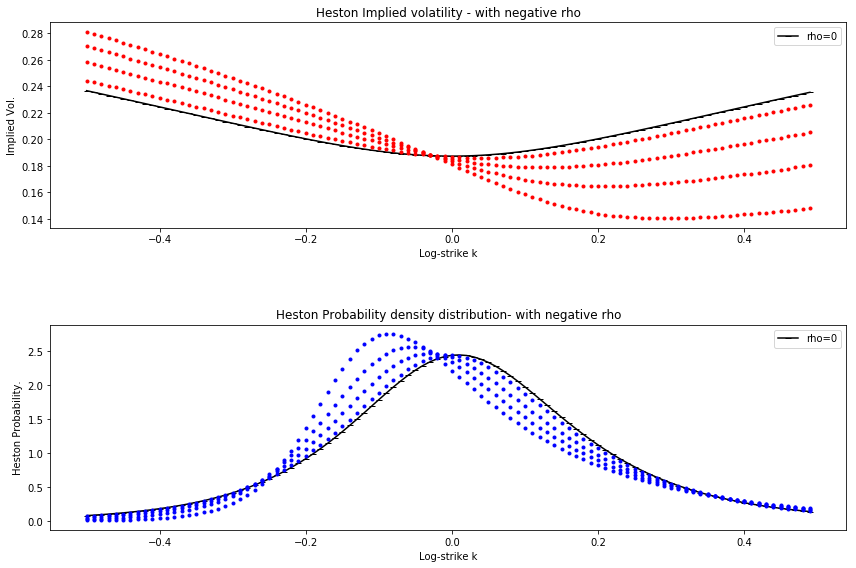

In [32]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.title('Heston Implied volatility - with negative rho')
plt.ylabel('Implied Vol.')
plt.xlabel('Log-strike k')
plt.plot(log_strike, f0, color='black', linestyle='-', marker='_')
plt.plot(log_strike, f1, color='red', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f2, color='red', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f3, color='red', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f4, color='red', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['rho=0'], loc='upper right')

plt.subplot(212)
plt.title('Heston Probability density distribution- with negative rho')
plt.ylabel('Heston Probability.')
plt.xlabel('Log-strike k')
plt.plot(log_strike, pdf0, color='black', linestyle='-', marker='_')
plt.plot(log_strike, pdf1, color='blue', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf2, color='blue', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf3, color='blue', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf4, color='blue', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['rho=0'], loc='upper right')

plt.tight_layout(h_pad=5)
plt.show()

### for rho > 0 case

In [19]:
f0 = [impvolHeston(kappa=1.15, rho=0, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f5 = [impvolHeston(kappa=1.15, rho=0.1, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f6 = [impvolHeston(kappa=1.15, rho=0.3, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f7 = [impvolHeston(kappa=1.15, rho=0.5, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f8 = [impvolHeston(kappa=1.15, rho=0.7, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

pdf0 = [pdf_Heston(kappa=1.15, rho=0, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf5 = [pdf_Heston(kappa=1.15, rho=0.1, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf6 = [pdf_Heston(kappa=1.15, rho=0.3, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf7 = [pdf_Heston(kappa=1.15, rho=0.5, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf8 = [pdf_Heston(kappa=1.15, rho=0.7, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

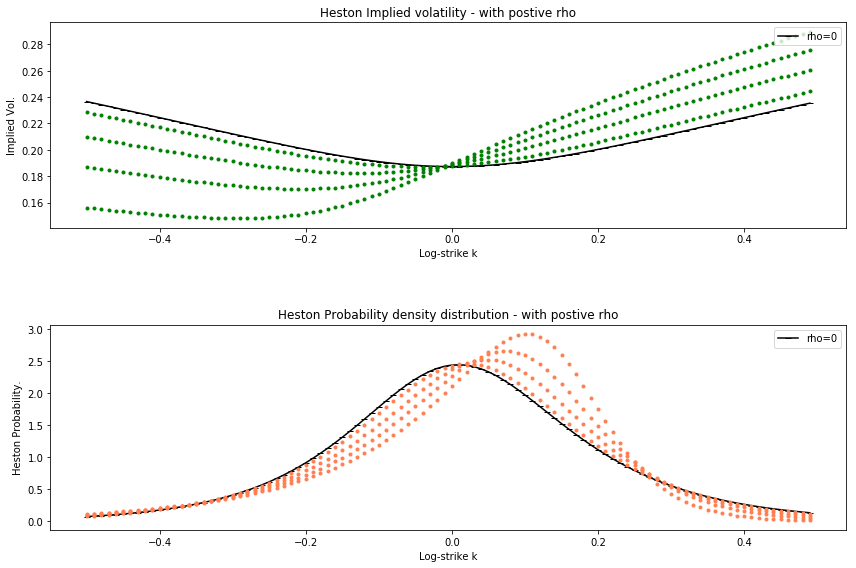

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.title('Heston Implied volatility - with postive rho')
plt.ylabel('Implied Vol.')
plt.xlabel('Log-strike k')
plt.plot(log_strike, f0, color='black', linestyle='-', marker='_')
plt.plot(log_strike, f5, color='green', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f6, color='green', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f7, color='green', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f8, color='green', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['rho=0'], loc='upper right')

plt.subplot(212)
plt.title('Heston Probability density distribution - with postive rho')
plt.ylabel('Heston Probability.')
plt.xlabel('Log-strike k')
plt.plot(log_strike, pdf0, color='black', linestyle='-', marker='_')
plt.plot(log_strike, pdf5, color='coral', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf6, color='coral', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf7, color='coral', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf8, color='coral', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['rho=0'], loc='upper right')

plt.tight_layout(h_pad=5)
plt.show()

## 3. Sensitivity of the Heston smile to theta

In [21]:
f00 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

f01 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.49, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f02 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.59, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f03 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.69, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f04 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.79, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f05 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.89, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

pdf00 = [pdf_Heston(kappa=1.15, rho=0, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

pdf01 = [pdf_Heston(kappa=1.15, rho=-0.64, nu=0.49, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf02 = [pdf_Heston(kappa=1.15, rho=-0.64, nu=0.59, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf03 = [pdf_Heston(kappa=1.15, rho=-0.64, nu=0.69, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf04 = [pdf_Heston(kappa=1.15, rho=-0.64, nu=0.79, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
pdf05 = [pdf_Heston(kappa=1.15, rho=-0.64, nu=0.89, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

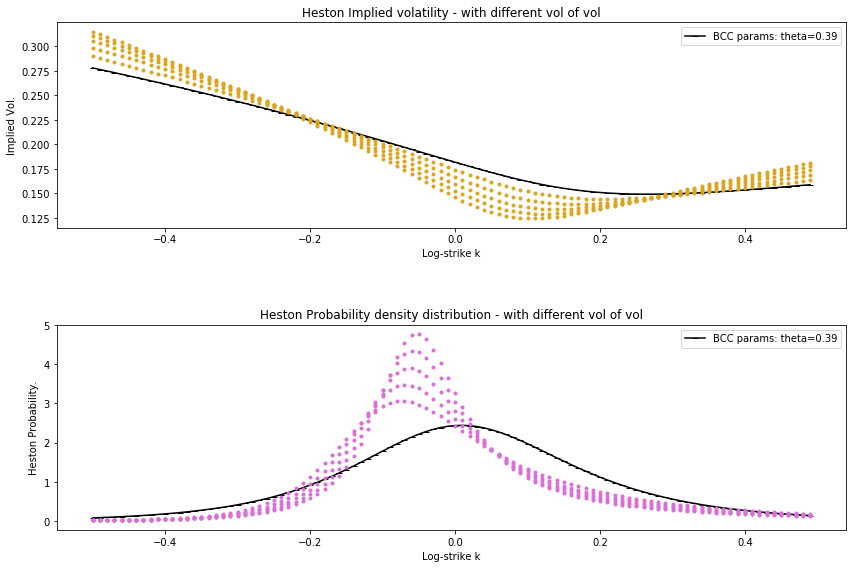

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.title('Heston Implied volatility - with different vol of vol')
plt.ylabel('Implied Vol.')
plt.xlabel('Log-strike k')
plt.plot(log_strike, f00, color='black', linestyle='-', marker='_')
plt.plot(log_strike, f01, color='goldenrod', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f02, color='goldenrod', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f03, color='goldenrod', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f04, color='goldenrod', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f05, color='goldenrod', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['BCC params: theta=0.39'], loc='upper right')

plt.subplot(212)
plt.title('Heston Probability density distribution - with different vol of vol')
plt.ylabel('Heston Probability.')
plt.xlabel('Log-strike k')
plt.plot(log_strike, pdf00, color='black', linestyle='-', marker='_')
plt.plot(log_strike, pdf01, color='orchid', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf02, color='orchid', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf03, color='orchid', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf04, color='orchid', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, pdf05, color='orchid', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['BCC params: theta=0.39'], loc='upper right')

plt.tight_layout(h_pad=5)
plt.show()

## 4. Sensitivity of the Heston smile to kappa

In [23]:
f10 = [impvolHeston(kappa=1.15, rho=-0.64, nu=0.39, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f11 = [impvolHeston(kappa=1.65, rho=-0.64, nu=0.49, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f12 = [impvolHeston(kappa=2.15, rho=-0.64, nu=0.59, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f13 = [impvolHeston(kappa=2.65, rho=-0.64, nu=0.69, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f14 = [impvolHeston(kappa=3.15, rho=-0.64, nu=0.79, theta=0.04, v0=0.04)(i, 1) for i in log_strike]
f15 = [impvolHeston(kappa=3.65, rho=-0.64, nu=0.89, theta=0.04, v0=0.04)(i, 1) for i in log_strike]

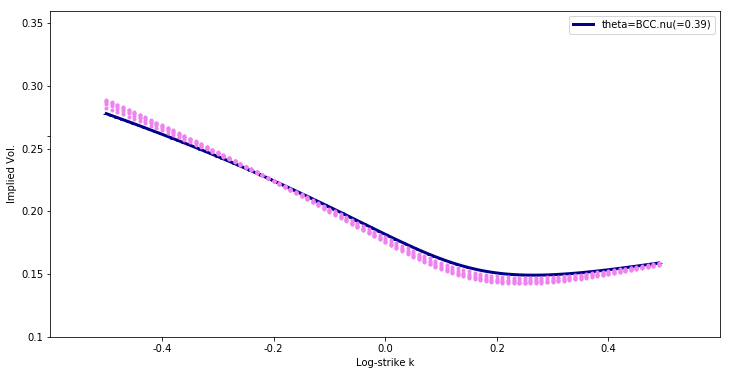

In [24]:
plt.figure(figsize=(12, 6))
plt.ylabel('Implied Vol.')
plt.xlabel('Log-strike k')
plt.xlim(-0.6, 0.6)
plt.ylim(0.14, 0.36)
plt.xticks([-0.4, -0.2, 0, 0.2, 0.4],[r'-0.4',r'-0.2',r'0.0',r'0.2',r'0.4'])
plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.26],[r'0.1', r'0.15',r'0.20',r'0.25',r'0.30',r'0.35'])

plt.plot(log_strike, f10, color='darkblue', linewidth=3, linestyle='-', marker='_')
plt.plot(log_strike, f11, color='violet', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f12, color='violet', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f13, color='violet', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f14, color='violet', linewidth=0.01, linestyle='-', marker='.')
plt.plot(log_strike, f15, color='violet', linewidth=0.01, linestyle='-', marker='.')
plt.legend(['theta=BCC.nu(=0.39)'], loc='upper right')
plt.show()

# MC method

In [33]:
nSteps = 50   # Number of time steps
nPaths = 10000   # Number of monte carlo paths
K = 100   # Strike
texp = 1.0   # maturity
s0 = 90   # Initial stock price
v0 = 0.0225   # Initial volatility
intr = 0.03  # risk free rate
theta = 0.0225   # long term volatility mean
kappa = 2   # Mean reversion speed of volatility
nu = 0.0225   # vol of vol
rho = -0.5   # correlation

## Euler Discretization

In [36]:
np.random.seed(42)
def call_payoff(underlying_path):   # the payoff for call option
    return np.fmax(underlying_path - K, 0)

def generate_path(dt):  # generate stock price path
    # create vectors, zeros(nSteps+1) becasue we'll put s0 in it
    # nSteps is the number of time steps
    s = np.zeros(nSteps+1)  
    v = np.zeros(nSteps+1)
    s[0] = s0  # stock price       
    v[0] = v0  # volatility
    dW1 = np.random.normal(size=nSteps)  # the standard nomral used for Stock price
    # use two uncorrelated normal random variables to create two coreelated RVs with correlation rho
    dW2 = rho*dW1 + np.sqrt(1-rho**2)*np.random.normal(size=nSteps)   
     
    for j in range(0, nSteps):
        s[j+1] = s[j]*np.exp((intr-0.5*v[j])*dt + np.sqrt(v[j]*dt)*dW1[j])
        v[j+1] = np.fmax(v[j]+(kappa*(theta-v[j])*dt) + nu*np.sqrt(v[j]*dt)*dW2[j], 0)
    return s[nSteps]   # return the the value at time to maturity


# Pricing with Euler Discretization
def Euler_sim_price(nPaths):
    payOff_Sum = [call_payoff(generate_path(texp / nSteps)) for i in range(0, nPaths)]    # texp/nSteps = dt
    Euler_sim_price = np.exp(-intr*texp) * np.mean(payOff_Sum)   # present value
    return Euler_sim_price
print(Euler_sim_price(nPaths=10000))

2.7274455194936507


## Milstein Discretization

In [37]:
np.random.seed(42)
def generate_path_Mil(dt):
    s = np.zeros(nSteps+1)
    v = np.zeros(nSteps+1)
    s[0] = s0            
    v[0] = v0
    dW1 = standard_normal(nSteps)
    dW2 = rho*dW1 + np.sqrt(1-rho**2)*standard_normal(nSteps)
    for j in range(0, nSteps):
        s[j+1] = s[j]*np.exp((intr-0.5*v[j])*dt + np.sqrt(v[j]*dt)*dW1[j])
        v[j+1] = np.fmax((kappa*(theta-v[j])*dt) - (0.25*(nu**2)*dt) + \
                       (np.sqrt(v[j]) + 0.5*nu*dW2[j]*(np.sqrt(dt)))**2, 0)
    return s[nSteps]           
    

# Pricing with Milstein Discretization
def Mil_sim_price(nPaths):
    payOff_Sum = [call_payoff(generate_path_Mil(texp / nSteps)) for i in range(0, nPaths)]    # texp/nSteps = dt
    Mil_sim_price = np.exp(-intr*texp) * np.mean(payOff_Sum)   # present value
    return Mil_sim_price
print(Mil_sim_price(nPaths=10000))

2.727460900595659


# Visulaize the convergence

In [40]:
Path_range = np.arange(1000, 100000, 2000)

In [41]:
Euler_simprice = [Euler_sim_price(p) for p in Path_range]

In [42]:
Mil_simprice = [Mil_sim_price(p) for p in Path_range]

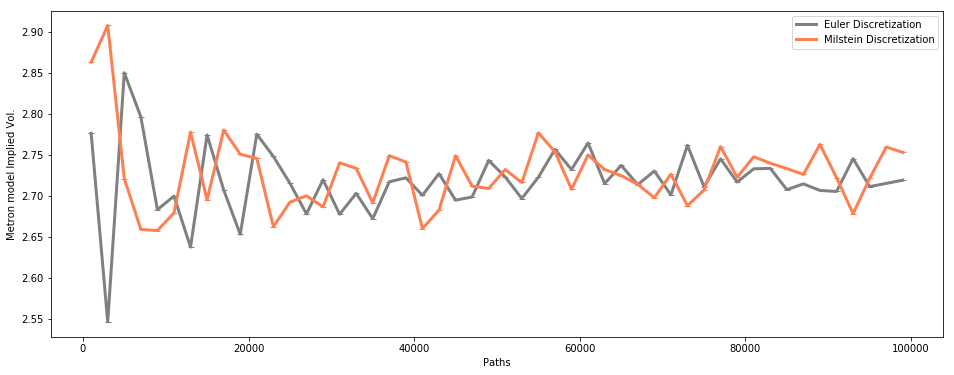

In [43]:
plt.figure(figsize=(16, 6))
plt.ylabel('Metron model Implied Vol.')
plt.xlabel('Paths')
plt.plot(Path_range, Euler_simprice, color='grey', linewidth=3, linestyle='-', marker='_')
plt.plot(Path_range, Mil_simprice, color='coral', linewidth=3, linestyle='-', marker='_')

plt.legend(['Euler Discretization','Milstein Discretization'], loc='upper right')

plt.show()

# Jump diffsuion

In [5]:
from pyfe import bsm
from pyfe import lewis_method

In [6]:
strike = np.arange(60, 140, 1)

In [7]:
# Heston parameters
T=1
r=0.03   # interest rate
kappa_v=2
theta_v=0.0225
sigma_v=0.25
rho=-0.5
v0=0.0225  # initial value of volatility

In [8]:
Heston = [lewis_method.H93_call_value(90, k, T=1, r=0.03, kappa_v=2, theta_v=0.0225, sigma_v=0.25, rho=-0.5, v0=0.0225) for k in strike]

In [9]:
# Jump diffusion parameters
S0=100
T=1
r=0.03
sigma=0.15
lamb=0.4
delta=np.sqrt(0.16)

In [10]:
mu=[-0.3, -0.5, -0.7, -0.9]

In [11]:
Merton0 = [lewis_method.M76_value_call_INT(90, k, T, r, sigma, lamb, mu=-0.3, delta=np.sqrt(0.16)) for k in strike]
Merton1 = [lewis_method.M76_value_call_INT(90, k, T, r, sigma, lamb, mu=-0.5, delta=np.sqrt(0.16)) for k in strike]
Merton2 = [lewis_method.M76_value_call_INT(90, k, T, r, sigma, lamb, mu=-0.7, delta=np.sqrt(0.16)) for k in strike]
Merton3 = [lewis_method.M76_value_call_INT(90, k, T, r, sigma, lamb, mu=-0.9, delta=np.sqrt(0.16)) for k in strike]

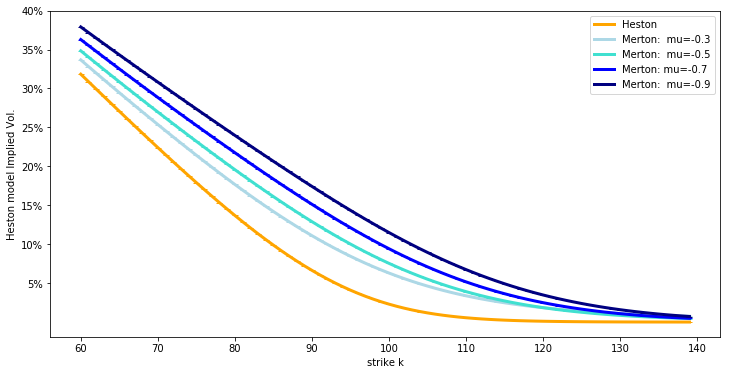

In [20]:
plt.figure(figsize=(12, 6))
plt.ylabel('Heston model Implied Vol.')
plt.xlabel('strike k')

plt.plot(strike, Heston, color='orange', linewidth=3, linestyle='-', marker='_')
plt.plot(strike, Merton0, color='lightblue', linewidth=3, linestyle='-', marker='_')
plt.plot(strike, Merton1, color='turquoise', linewidth=3, linestyle='-', marker='_')
plt.plot(strike, Merton2, color='blue', linewidth=3, linestyle='-', marker='_')
plt.plot(strike, Merton3, color='navy', linewidth=3, linestyle='-', marker='_')

plt.yticks([5, 10, 15, 20, 25, 30, 35, 40],[r'5%',r'10%',r'15%',r'20%',r'25%',r'30%', r'35%',r'40%'])
plt.legend(['Heston','Merton:  mu=-0.3', 'Merton:  mu=-0.5','Merton: mu=-0.7','Merton:  mu=-0.9'], loc='upper right')

plt.show()